## Imports

In [2]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.metrics import *
from general_analysis import *
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from explore_hyperparameter import *
import math
from plot_learning_curve import *
from sklearn.preprocessing import StandardScaler
import time

from sklearn.ensemble import RandomForestClassifier

from sklearn.random_projection import SparseRandomProjection


from sklearn.manifold import TSNE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
from sklearn.metrics import adjusted_mutual_info_score as ami
import sys
import os
from sklearn.decomposition import *

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 5000 #to keep results consistent


import scipy.sparse as sparse
from scipy.linalg import pinv

from sklearn.datasets import make_blobs

from clustering import *


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load Data

### Separate X and y

In [3]:
data = []
f = open('spambase.data')
readcsv = csv.reader(f)
classes = next(readcsv, None)
print(classes)
for row in readcsv:
    data.append(row)
f.close()

word_labels = ['address', 'all', '3d', 'our', 'over', 'remove', 'internet',
               'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses',
               'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000',
               'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857',
               'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct',
               'cs', 'meeting', 'original', 'project', 're', 'edu', 'table', 'conference']



['0', '0.64', '0.64', '0', '0.32', '0', '0', '0', '0', '0', '0', '0.64', '0', '0', '0', '0.32', '0', '1.29', '1.93', '0', '0.96', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.778', '0', '0', '3.756', '61', '278', '1']


In [4]:
X = np.array([x[:-1] for x in data]).astype(np.float)
y = np.array([x[-1] for x in data]).astype(np.float)
X = X[:, 0:57]
X = StandardScaler().fit_transform(X)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = RANDOM_STATE)
X_train = X_train[:, 0:57]
X_test = X_test[:, 0:57]
y_test = y_test.astype(int)
y_train = y_train.astype(int)
y_test = np.array(y_test)



# PCA

[ 11.3  16.9  20.7  23.9  26.9  29.6  32.2  34.7  37.1  39.4  41.7  43.9
  46.   48.1  50.1  52.1  54.   55.9  57.8  59.7  61.5  63.3  65.1  66.8
  68.5  70.1  71.7  73.3  74.8  76.3  77.7  79.1  80.4  81.7  83.   84.3
  85.5  86.7  87.9  89.   90.1  91.2  92.2  93.2  94.2  95.   95.8  96.6
  97.3  98.   98.6  99.1  99.5  99.8 100.  100.2 100.2]


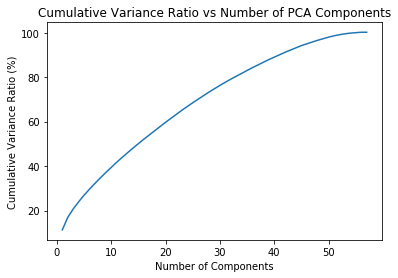

In [70]:
#https://etav.github.io/python/scikit_pca.html
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(random_state=RANDOM_STATE, n_components = 57).fit(X_train)
current_var = pca.explained_variance_ratio_
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

n_components = range(1, 58)
plt.figure(1)
plt.plot(n_components, var)
plt.title('Cumulative Variance Ratio vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio (%)')
plt.savefig('spam_pca_variance.png')

print(var)
    


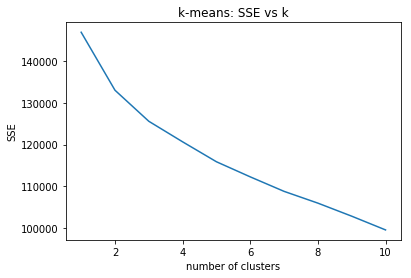

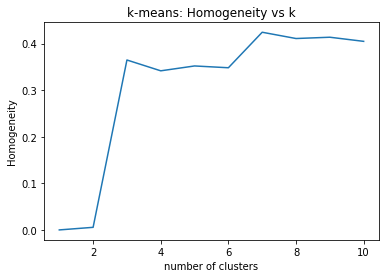

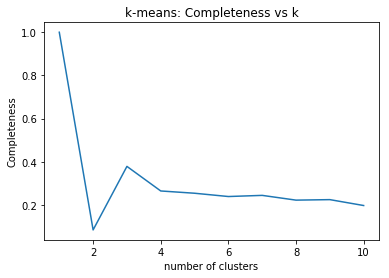

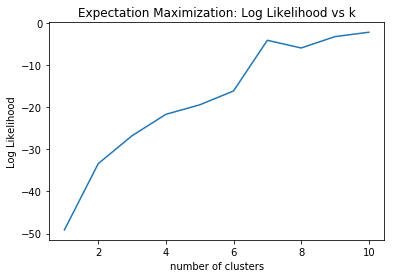

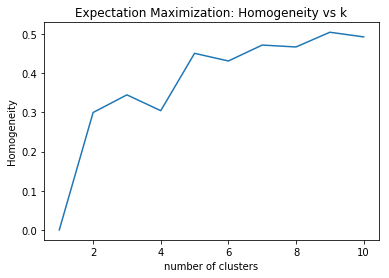

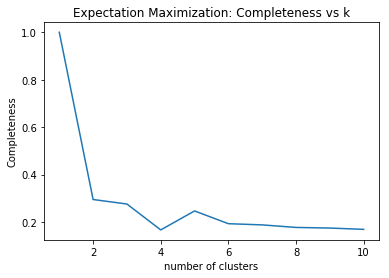

In [6]:
#32 features is around 80% of the variance
pca = PCA(random_state=RANDOM_STATE, n_components=32).fit(X_train)
x_pca = pca.transform(X_train)

km = kmeans(random_state=RANDOM_STATE)
gmm = GMM(random_state=RANDOM_STATE)

problem_name = "spam_pca"
cluster_range = range(1, 11)
clustering(x_pca, y_train, cluster_range, problem_name)



In [78]:
num_components = 57
pca_train_scores = []
pca_test_scores = []
train_f1_scores = []
test_f1_scores = []
train_recall_scores = []
test_recall_scores = []
train_precision_scores = []
test_precision_scores = []
times = []
for i in range(1, num_components+1):
    print("i = " + str(i))
    pca = PCA(random_state = RANDOM_STATE, n_components=i).fit(X)
    x_pca = pca.transform(X)
    start = time.time()
    x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y, test_size=0.3, random_state = RANDOM_STATE)
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    
    clf.fit(x_pca_train, y_pca_train)
    end = time.time()
    times.append(end-start)
    train_pred = clf.predict(x_pca_train)
    train_score = accuracy_score(y_pca_train, train_pred)
    pca_train_scores.append(train_score)
    test_pred = clf.predict(x_pca_test)
    test_score = accuracy_score(y_pca_test, test_pred)
    pca_test_scores.append(test_score)
    
    
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    
    
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    

with open('spam_pca_nn.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(pca_train_scores)
    csvwriter.writerow(pca_test_scores)
    csvwriter.writerow(train_f1_scores)
    csvwriter.writerow(test_f1_scores)
    csvwriter.writerow(train_recall_scores)
    csvwriter.writerow(test_recall_scores)
    csvwriter.writerow(train_precision_scores)
    csvwriter.writerow(test_precision_scores)
    csvwriter.writerow(times)


i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57


In [37]:
#normal neural network

clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes=(57))
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
runtime = end - start
train_pred = clf.predict(X_train)
orig_train_score = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_precision = precision_score(y_train, train_pred, average='weighted')
test_pred = clf.predict(X_test)
orig_test_score = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_precision = precision_score(y_test, test_pred, average='weighted')



with open('spam_orig_nn.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow([orig_train_score])
    csvwriter.writerow([orig_test_score])
    csvwriter.writerow([train_f1])
    csvwriter.writerow([test_f1])
    csvwriter.writerow([train_recall])
    csvwriter.writerow([test_recall])
    csvwriter.writerow([train_precision])
    csvwriter.writerow([test_precision])
    csvwriter.writerow([runtime])
    



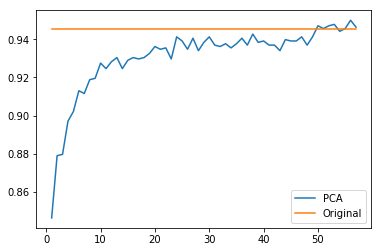

In [9]:
plt.figure(1)
plt.plot(range(1, num_components+1), pca_test_scores)
plt.plot([1, num_components], [orig_test_score, orig_test_score])
plt.legend(['PCA', 'Original'])






# ICA

[2074.223073626851, 1361.393424055964, 1098.5976446364969, 901.5953569996307, 662.4181547522116, 623.0096223168925, 542.7584022717417, 537.9635300017923, 450.0803630270409, 395.9935774384232, 370.68186993214204, 364.43686754179885, 331.79468423885265, 326.01966261800646, 320.5903673143133, 267.3498413721276, 240.32756926644794, 236.51389498211014, 226.2504655702009, 221.76758734073812, 197.2965368134621, 194.19826548712578, 181.1423720485655, 180.9666795907635, 134.76540546562094, 132.98406675458307, 124.262067517128, 118.6387947545026, 116.07529718888637, 114.32454375675876, 110.89106627845653, 109.67481556317844, 102.10614312602554, 101.13987300584276, 88.61194506424373, 84.779346161891, 83.77621052976127, 82.76802188975967, 76.76039107861541, 75.49518750966102, 61.595804035769774, 61.01241477575796, 55.39763252921696, 52.120030311888925, 47.31135058917198, 46.44201556720391, 44.65865361802463, 41.61234899499258, 40.158494253876334, 35.35149476845247, 34.1572319146963, 29.07268595421

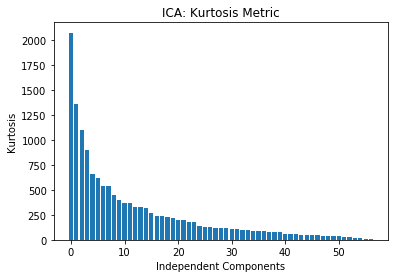

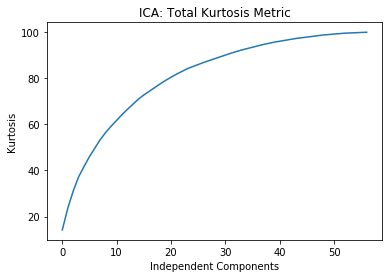

In [75]:
#fast ica
ica = FastICA(random_state=RANDOM_STATE)
x_ica = ica.fit_transform(X_train)
x_ica = pd.DataFrame(x_ica)
x_kurt = sorted(x_ica.kurt(), reverse=True)
x_kurt_norm = x_kurt / np.sum(x_kurt)
var=np.cumsum(np.round(x_kurt_norm, decimals=3)*100)


print(sorted(x_kurt, reverse=True))

plt.bar(range(len(x_kurt)),x_kurt)
plt.xlabel('Independent Components')
plt.ylabel('Kurtosis') 
plt.title('ICA: Kurtosis Metric')
plt.savefig('spam_ica_kurtosis.png')

plt.figure(2)
plt.plot(range(len(x_kurt)), var)
plt.xlabel('Independent Components')
plt.ylabel('Kurtosis') 
plt.title('ICA: Total Kurtosis Metric')
plt.savefig('spam_ica_total_kurtosis.png')






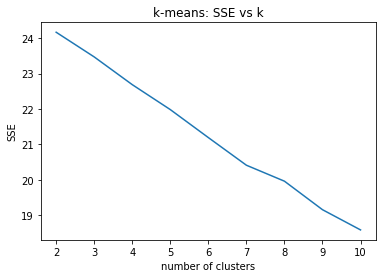

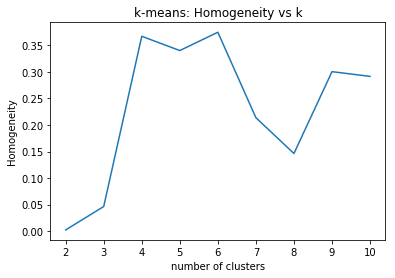

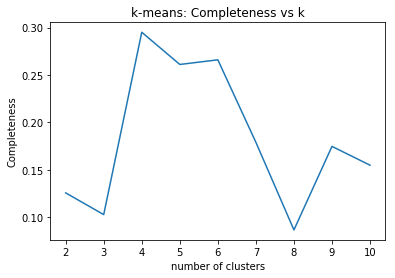

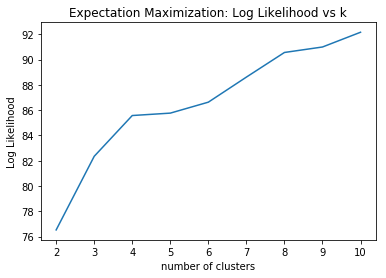

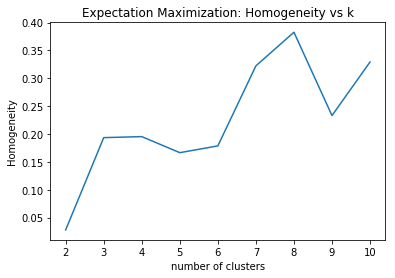

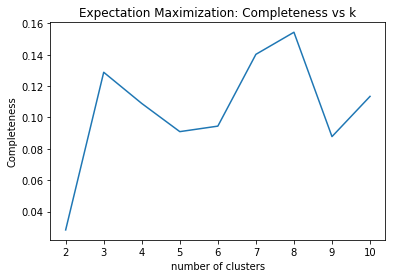

In [79]:
#choose number of components, since im still not sure how this affects results...
N_COMPONENTS = 25 #57 is the max
ica = FastICA(random_state=RANDOM_STATE, n_components=N_COMPONENTS)
x_ica = ica.fit_transform(X_train)
# x_ica = pd.DataFrame(x_ica)

problem_name = "spam_ica"
cluster_range = range(2, 11)
clustering(x_ica, y_train, cluster_range, problem_name)








In [12]:
num_components = 57
ica_train_scores = []
ica_test_scores = []
times = []
train_f1_scores = []
test_f1_scores = []
train_recall_scores = []
test_recall_scores = []
train_precision_scores = []
test_precision_scores = []
for i in range(1, num_components+1):
    print("i = " + str(i))
    ica = FastICA(random_state = RANDOM_STATE, n_components=i)
    x_ica = ica.fit_transform(X)
    start = time.time()
    x_ica_train, x_ica_test, y_ica_train, y_ica_test = train_test_split(x_ica, y, test_size=0.3, random_state = RANDOM_STATE)
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    
    clf.fit(x_ica_train, y_ica_train)
    end = time.time()
    times.append(end-start)
    train_pred = clf.predict(x_ica_train)
    train_score = accuracy_score(y_ica_train, train_pred)
    ica_train_scores.append(train_score)
    test_pred = clf.predict(x_ica_test)
    test_score = accuracy_score(y_ica_test, test_pred)
    ica_test_scores.append(test_score)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    
    

    

with open('spam_ica_nn.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(ica_train_scores)
    csvwriter.writerow(ica_test_scores)
    csvwriter.writerow(train_f1_scores)
    csvwriter.writerow(test_f1_scores)
    csvwriter.writerow(train_recall_scores)
    csvwriter.writerow(test_recall_scores)
    csvwriter.writerow(train_precision_scores)
    csvwriter.writerow(test_precision_scores)
    csvwriter.writerow(times)


i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57


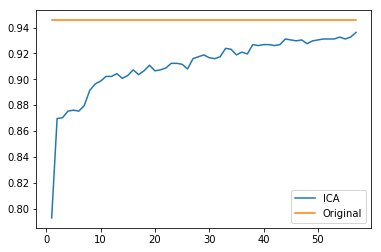

In [13]:
plt.figure(1)
plt.plot(range(1, num_components+1), ica_test_scores)
plt.plot([1, num_components], [orig_test_score, orig_test_score])
plt.legend(['ICA', 'Original'])






# RP

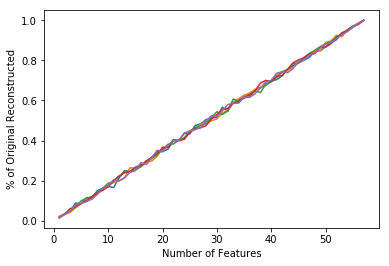

In [15]:
def reconstructedRatio(projections,X):
    #https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
    #https://piazza.com/class/jzh7b4sw45n6rv?cid=567
    comps = projections.components_.todense()
    mat = pinv(comps) #take psuedo inverse of projection matrix
    reconstructed = np.matmul((np.matmul(mat,comps)),(np.transpose(X)))
    errors = np.square(reconstructed-np.transpose(X))
    return 1 - np.mean(errors)

ratios = []
for iters in range(5):
    currentratios = []
    for i in range(1, 58):
        rp = SparseRandomProjection(random_state = RANDOM_STATE + iters * 100, n_components=i)
        rp.fit(X)
        currentratios.append(reconstructedRatio(rp, X))
    ratios.append(currentratios)
    
plt.figure(1)
for i in range(5):
    plt.plot(range(1,58), ratios[i])
plt.xlabel('Number of Features')
plt.ylabel('% of Original Reconstructed')
plt.savefig('spam_rp_reconstruction.png')


# UPDATE THIS CELL BELOW!!!!!!

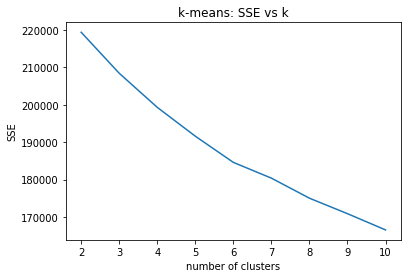

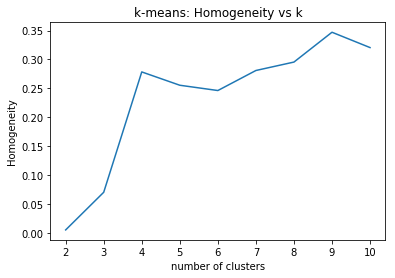

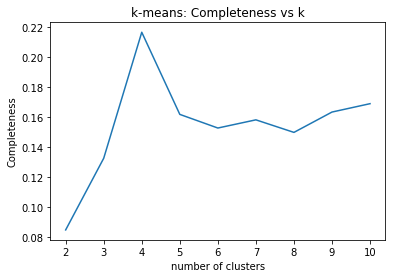

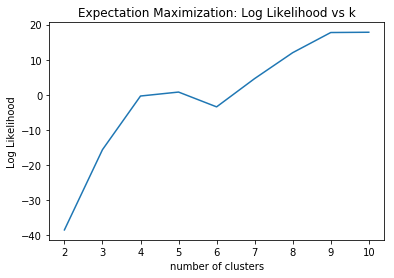

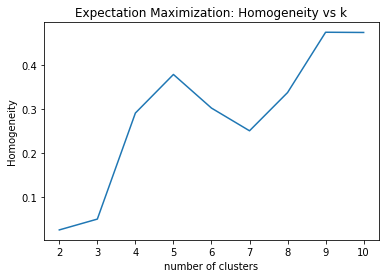

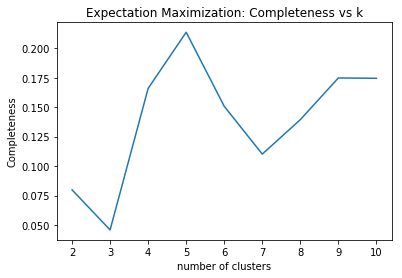

In [15]:
#45 is 80% reconstructed
N_COMPONENTS = 45 #57 is the max
rp = SparseRandomProjection(random_state=RANDOM_STATE, n_components=N_COMPONENTS)
x_rp = rp.fit_transform(X)


problem_name = "spam_rp"
cluster_range = range(2, 11)
clustering(x_rp, y, cluster_range, problem_name)

In [16]:
num_components = 57
rp_train_scores = []
rp_test_scores = []
times = []
train_f1_scores = []
test_f1_scores = []
train_recall_scores = []
test_recall_scores = []
train_precision_scores = []
test_precision_scores = []
for i in range(1, num_components+1):
    print("i = " + str(i))
    rp = SparseRandomProjection(random_state = RANDOM_STATE, n_components=i)
    x_rp = rp.fit_transform(X)
    start = time.time()
    x_rp_train, x_rp_test, y_rp_train, y_rp_test = train_test_split(x_rp, y, test_size=0.3, random_state = RANDOM_STATE)
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    
    clf.fit(x_rp_train, y_rp_train)
    end = time.time()
    times.append(end-start)
    train_pred = clf.predict(x_rp_train)
    train_score = accuracy_score(y_rp_train, train_pred)
    rp_train_scores.append(train_score)
    test_pred = clf.predict(x_rp_test)
    test_score = accuracy_score(y_rp_test, test_pred)
    rp_test_scores.append(test_score)
    
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    

with open('spam_rp_nn.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(rp_train_scores)
    csvwriter.writerow(rp_test_scores)
    csvwriter.writerow(train_f1_scores)
    csvwriter.writerow(test_f1_scores)
    csvwriter.writerow(train_recall_scores)
    csvwriter.writerow(test_recall_scores)
    csvwriter.writerow(train_precision_scores)
    csvwriter.writerow(test_precision_scores)
    csvwriter.writerow(times)


i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57


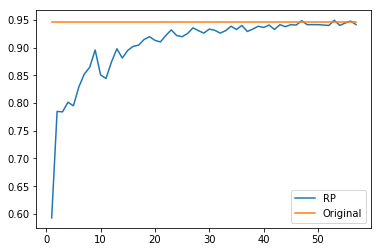

In [17]:
plt.figure(1)
plt.plot(range(1, num_components+1), rp_test_scores)
plt.plot([1, num_components], [orig_test_score, orig_test_score])
plt.legend(['RP', 'Original'])






# RF

[ 11.8  19.9  26.8  33.5  40.1  46.   51.7  57.1  61.9  65.1  68.2  71.
  73.5  76.   78.1  80.   81.4  82.8  84.2  85.4  86.5  87.6  88.6  89.6
  90.4  91.1  91.8  92.4  93.   93.5  94.   94.5  94.9  95.3  95.7  96.
  96.3  96.6  96.9  97.2  97.5  97.8  98.1  98.3  98.5  98.7  98.9  99.1
  99.3  99.5  99.7  99.8  99.9 100.  100.  100.  100. ]


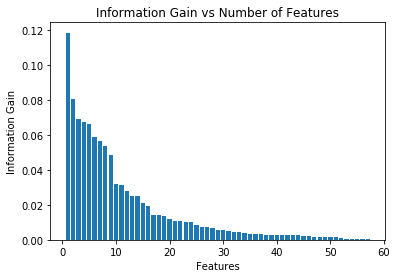

In [16]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
features = sorted(rf.fit(X_train, y_train).feature_importances_, reverse=True)
x_axis = range(1, 58)
plt.bar(x_axis,features)
plt.xlabel('Features')
plt.ylabel('Information Gain')
plt.title('Information Gain vs Number of Features')
plt.savefig('spam_rf_infogain.png')

#16 features is 80%
var=np.cumsum(np.round(features, decimals=3)*100)
print(var)


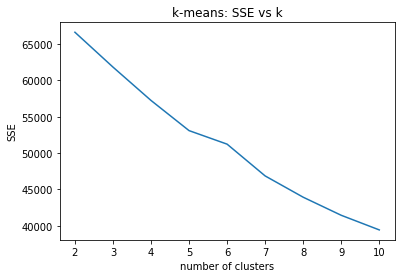

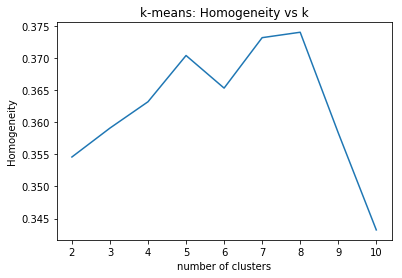

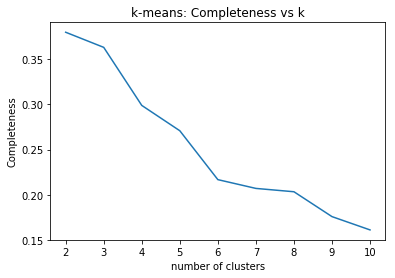

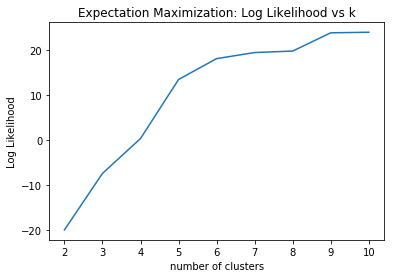

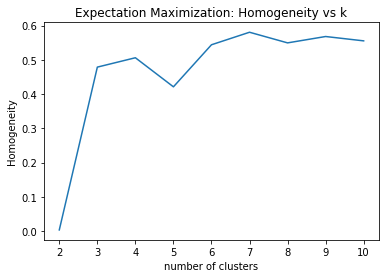

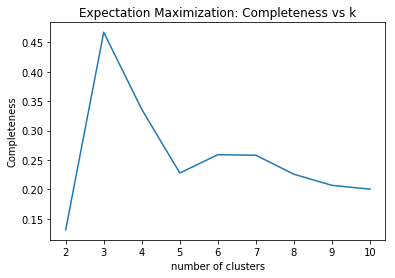

In [19]:
#16 features is 80%
N_COMPONENTS = 16 #57 is the max
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
rf_fit = rf.fit(X,y)
features = rf_fit.feature_importances_

sorted_features = sorted(features, reverse=True) #greatest to least
sorted_features_index = np.argsort(features)
sorted_features_index = np.flip(sorted_features_index)
sorted_features_index = sorted_features_index.tolist()
#how many features do you want?
keep_features = N_COMPONENTS
x_rf = np.delete(X, sorted_features_index[keep_features:], axis=1) #delete the ones we dont want


problem_name = "spam_rf"
cluster_range = range(2, 11)
clustering(x_rf, y, cluster_range, problem_name)

In [20]:
num_components = 57
rf_train_scores = []
rf_test_scores = []
times = []
train_f1_scores = []
test_f1_scores = []
train_recall_scores = []
test_recall_scores = []
train_precision_scores = []
test_precision_scores = []
for i in range(1, num_components+1):
    print("i = " + str(i))
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
    rf_fit = rf.fit(X, y)
    features = rf_fit.feature_importances_

    sorted_features = sorted(features, reverse=True) #greatest to least
    sorted_features_index = np.argsort(features)
    sorted_features_index = np.flip(sorted_features_index)
    sorted_features_index = sorted_features_index.tolist()
    #how many features do you want?
    keep_features = i
    x_rf = np.delete(X, sorted_features_index[keep_features:], axis=1) #delete the ones we dont want
    start = time.time()
    x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(x_rf, y, test_size=0.3, random_state = RANDOM_STATE)
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    
    clf.fit(x_rf_train, y_rf_train)
    end = time.time()
    times.append(end-start)
    train_pred = clf.predict(x_rf_train)
    train_score = accuracy_score(y_rf_train, train_pred)
    rf_train_scores.append(train_score)
    test_pred = clf.predict(x_rf_test)
    test_score = accuracy_score(y_rf_test, test_pred)
    
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    
    rf_test_scores.append(test_score)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    

with open('spam_rf_nn.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(rf_train_scores)
    csvwriter.writerow(rf_test_scores)
    csvwriter.writerow(train_f1_scores)
    csvwriter.writerow(test_f1_scores)
    csvwriter.writerow(train_recall_scores)
    csvwriter.writerow(test_recall_scores)
    csvwriter.writerow(train_precision_scores)
    csvwriter.writerow(test_precision_scores)
    csvwriter.writerow(times)


i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57


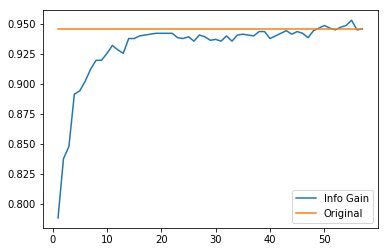

In [21]:
plt.figure(1)
plt.plot(range(1, num_components+1), rf_test_scores)
plt.plot([1, num_components], [orig_test_score, orig_test_score])
plt.legend(['Info Gain', 'Original'])






# PLOT ALL

## NEW ANALYSIS


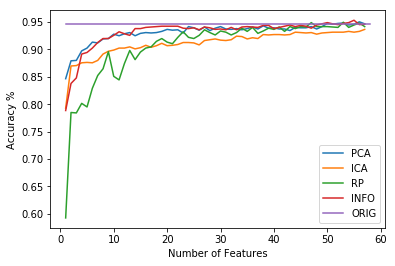

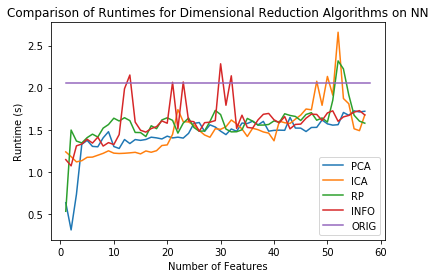

In [38]:
pca_nn_data = pd.read_csv('spam_pca_nn.txt', header=None)
ica_nn_data = pd.read_csv('spam_ica_nn.txt', header=None)
rp_nn_data = pd.read_csv('spam_rp_nn.txt', header=None)
rf_nn_data = pd.read_csv('spam_rf_nn.txt', header=None)
orig_nn_data = pd.read_csv('spam_orig_nn.txt', header=None)


#use iloc and these indices
training = 0
testing = 1
timing = 2

plt.figure(1)
x_range = range(1, 58)
plt.plot(x_range, pca_nn_data.iloc[testing])
plt.plot(x_range, ica_nn_data.iloc[testing])
plt.plot(x_range, rp_nn_data.iloc[testing])
plt.plot(x_range, rf_nn_data.iloc[testing])
plt.plot([1, 58], [orig_nn_data.iloc[testing], orig_nn_data.iloc[testing]])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy %')
#plt.title('Comparison of Dimension Reduction Algorithms on Neural Network Performance')
plt.legend(['PCA', 'ICA', 'RP', 'INFO', 'ORIG'])
plt.savefig('spam_nn_compare.png')

plt.figure(2)
plt.plot(x_range, pca_nn_data.iloc[8])
plt.plot(x_range, ica_nn_data.iloc[8])
plt.plot(x_range, rp_nn_data.iloc[8])
plt.plot(x_range, rf_nn_data.iloc[8])
plt.plot([1, 58], [orig_nn_data.iloc[8], orig_nn_data.iloc[8]])
plt.xlabel('Number of Features')
plt.ylabel('Runtime (s)')
plt.title('Comparison of Runtimes for Dimensional Reduction Algorithms on NN')
#plt.title('Comparison of Dimension Reduction Algorithms on Neural Network Performance')
plt.legend(['PCA', 'ICA', 'RP', 'INFO', 'ORIG'])






# CLUSTERING AS FEATURE

In [64]:
km = kmeans(random_state=RANDOM_STATE)
gmm = GMM(random_state=RANDOM_STATE)

clusters = range(2, 11)


km_train_scores = []
km_test_scores = []
em_train_scores = []
em_test_scores = []

km_train_f1_scores = []
km_test_f1_scores = []
km_train_recall_scores = []
km_test_recall_scores = []
km_train_precision_scores = []
km_test_precision_scores = []

em_train_f1_scores = []
em_test_f1_scores = []
em_train_recall_scores = []
em_test_recall_scores = []
em_train_precision_scores = []
em_test_precision_scores = []

km_time = []
em_time = []

for k in clusters:

    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(X_train)
    gmm.fit(X_train)
    train_kmeans = km.predict(X_train) #this is the cluster number
    train_em = gmm.predict(X_train) #this is the cluster number
    test_kmeans = km.predict(X_test)
    test_em = gmm.predict(X_test)
    
    #append to the X
    X_train_km = np.column_stack((X_train, train_kmeans))
    X_train_em = np.column_stack((X_train, train_em))
    X_test_km = np.column_stack((X_test, test_kmeans))
    X_test_em = np.column_stack((X_test, test_em))
    #first for kmeans
    start = time.time()
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    clf.fit(X_train_km, y_train)
    end = time.time()
    km_time.append(end-start)
    train_pred = clf.predict(X_train_km)
    train_score = accuracy_score(y_train, train_pred)
    test_pred = clf.predict(X_test_km)
    test_score = accuracy_score(y_test, test_pred)
    km_train_scores.append(train_score)
    km_test_scores.append(test_score)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    km_train_f1_scores.append(train_f1)
    km_test_f1_scores.append(test_f1)
    km_train_recall_scores.append(train_recall)
    km_test_recall_scores.append(test_recall)
    km_train_precision_scores.append(train_precision)
    km_test_precision_scores.append(test_precision)
    
    #now for em
    start = time.time()
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    clf.fit(X_train_em, y_train)
    em_time.append(time.time()-start)
    train_pred = clf.predict(X_train_em)
    train_score = accuracy_score(y_train, train_pred)
    test_pred = clf.predict(X_test_em)
    test_score = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    em_train_scores.append(train_score)
    em_test_scores.append(test_score)
    em_train_f1_scores.append(train_f1)
    em_test_f1_scores.append(test_f1)
    em_train_recall_scores.append(train_recall)
    em_test_recall_scores.append(test_recall)
    em_train_precision_scores.append(train_precision)
    em_test_precision_scores.append(test_precision)
    
    

with open('spam_kmeans_as_feature.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(km_train_scores)
    csvwriter.writerow(km_test_scores)
    csvwriter.writerow(km_train_f1_scores)
    csvwriter.writerow(km_test_f1_scores)
    csvwriter.writerow(km_train_recall_scores)
    csvwriter.writerow(km_test_recall_scores)
    csvwriter.writerow(km_train_precision_scores)
    csvwriter.writerow(km_test_precision_scores)
    csvwriter.writerow(km_time)
    
with open('spam_em_as_feature.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(em_train_scores)
    csvwriter.writerow(em_test_scores)
    csvwriter.writerow(em_train_f1_scores)
    csvwriter.writerow(em_test_f1_scores)
    csvwriter.writerow(em_train_recall_scores)
    csvwriter.writerow(em_test_recall_scores)
    csvwriter.writerow(em_train_precision_scores)
    csvwriter.writerow(em_test_precision_scores)
    csvwriter.writerow(em_time)
    
    

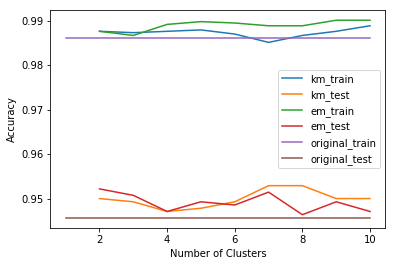

In [65]:
km_nn_data = pd.read_csv('spam_kmeans_as_feature.txt', header=None)
em_nn_data = pd.read_csv('spam_em_as_feature.txt', header=None)
orig_nn_data = pd.read_csv('spam_orig_nn.txt', header=None)

training = 0
testing = 1
plt.figure(2)
plt.plot(clusters, km_nn_data.iloc[training])
plt.plot(clusters, km_nn_data.iloc[testing])
plt.plot(clusters, em_nn_data.iloc[training])
plt.plot(clusters, em_nn_data.iloc[testing])
plt.plot([1,10], [orig_nn_data.iloc[training], orig_nn_data.iloc[training]])
plt.plot([1, 10], [orig_nn_data.iloc[testing], orig_nn_data.iloc[testing]])
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.legend(['km_train', 'km_test', 'em_train', 'em_test', 'original_train', 'original_test'])
plt.savefig('spam_clusters_as_feature.png')

# CLUSTERING AS ONLY FEATURE

In [66]:
km = kmeans(random_state=RANDOM_STATE)
gmm = GMM(random_state=RANDOM_STATE)

#clusters = [5, 10, 15, 20, 25, 30]
clusters = range(2, 11)


km_train_scores = []
km_test_scores = []
em_train_scores = []
em_test_scores = []

km_train_f1_scores = []
km_test_f1_scores = []
km_train_recall_scores = []
km_test_recall_scores = []
km_train_precision_scores = []
km_test_precision_scores = []
km_time = []

em_train_f1_scores = []
em_test_f1_scores = []
em_train_recall_scores = []
em_test_recall_scores = []
em_train_precision_scores = []
em_test_precision_scores = []
em_time = []
for k in clusters:

    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(X_train)
    gmm.fit(X_train)
    train_kmeans = np.reshape(km.predict(X_train), (-1, len(X_train))).T #this is the cluster number
    train_em = np.reshape(gmm.predict(X_train), (-1, len(X_train))).T #this is the cluster number
    test_kmeans = np.reshape(km.predict(X_test), (-1, len(X_test))).T
    test_em = np.reshape(gmm.predict(X_test), (-1, len(X_test))).T

#     train_kmeans = km.predict(X_train) #this is the cluster number
#     train_em = gmm.predict(X_train) #this is the cluster number
#     test_kmeans = km.predict(X_test)
#     test_em = gmm.predict(X_test)
    
    #append to the X
#     X_train_km = np.column_stack((X_train, train_kmeans))
#     X_train_em = np.column_stack((X_train, train_em))
#     X_test_km = np.column_stack((X_test, test_kmeans))
#     X_test_em = np.column_stack((X_test, test_em))
    #first for kmeans
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    start = time.time()
    clf.fit(train_kmeans, y_train)
    km_time.append(time.time() - start)
    train_pred = clf.predict(train_kmeans)
    train_score = accuracy_score(y_train, train_pred)
    test_pred = clf.predict(test_kmeans)
    test_score = accuracy_score(y_test, test_pred)
    km_train_scores.append(train_score)
    km_test_scores.append(test_score)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    km_train_f1_scores.append(train_f1)
    km_test_f1_scores.append(test_f1)
    km_train_recall_scores.append(train_recall)
    km_test_recall_scores.append(test_recall)
    km_train_precision_scores.append(train_precision)
    km_test_precision_scores.append(test_precision)
    
    #now for em
    clf = MLPClassifier(max_iter=200, random_state=RANDOM_STATE, hidden_layer_sizes = (57))
    start = time.time()
    clf.fit(train_em, y_train)
    em_time.append(time.time() - start)
    train_pred = clf.predict(train_em)
    train_score = accuracy_score(y_train, train_pred)
    test_pred = clf.predict(test_em)
    test_score = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')
    train_precision = precision_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_recall = recall_score(y_test, test_pred, average='weighted')
    test_precision = precision_score(y_test, test_pred, average='weighted')
    em_train_scores.append(train_score)
    em_test_scores.append(test_score)
    em_train_f1_scores.append(train_f1)
    em_test_f1_scores.append(test_f1)
    em_train_recall_scores.append(train_recall)
    em_test_recall_scores.append(test_recall)
    em_train_precision_scores.append(train_precision)
    em_test_precision_scores.append(test_precision)
    
    

with open('spam_kmeans_as_only_feature.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(km_train_scores)
    csvwriter.writerow(km_test_scores)
    csvwriter.writerow(km_train_f1_scores)
    csvwriter.writerow(km_test_f1_scores)
    csvwriter.writerow(km_train_recall_scores)
    csvwriter.writerow(km_test_recall_scores)
    csvwriter.writerow(km_train_precision_scores)
    csvwriter.writerow(km_test_precision_scores)
    csvwriter.writerow(km_time)
    
with open('spam_em_as_only_feature.txt', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(em_train_scores)
    csvwriter.writerow(em_test_scores)
    csvwriter.writerow(em_train_f1_scores)
    csvwriter.writerow(em_test_f1_scores)
    csvwriter.writerow(em_train_recall_scores)
    csvwriter.writerow(em_test_recall_scores)
    csvwriter.writerow(em_train_precision_scores)
    csvwriter.writerow(em_test_precision_scores)
    csvwriter.writerow(em_time)

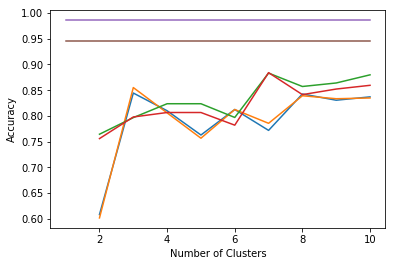

In [67]:
km_nn_data = pd.read_csv('spam_kmeans_as_only_feature.txt', header=None)
em_nn_data = pd.read_csv('spam_em_as_only_feature.txt', header=None)
orig_nn_data = pd.read_csv('spam_orig_nn.txt', header=None)

training = 0
testing = 1
plt.figure(2)
plt.plot(clusters, km_nn_data.iloc[training])
plt.plot(clusters, km_nn_data.iloc[testing])
plt.plot(clusters, em_nn_data.iloc[training])
plt.plot(clusters, em_nn_data.iloc[testing])
plt.plot([1, 10], [orig_nn_data.iloc[training], orig_nn_data.iloc[training]])
plt.plot([1, 10], [orig_nn_data.iloc[testing], orig_nn_data.iloc[testing]])
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
# plt.legend(['km_train', 'km_test', 'em_train', 'em_test', 'original_train', 'original_test'], loc='best')
plt.savefig('spam_clusters_as_only_feature.png')

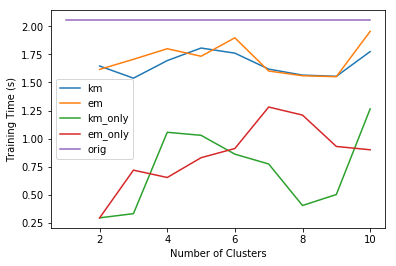

In [68]:
#time analysis
km_nn_data = pd.read_csv('spam_kmeans_as_feature.txt', header=None)
em_nn_data = pd.read_csv('spam_em_as_feature.txt', header=None)
km_nn_data_only = pd.read_csv('spam_kmeans_as_only_feature.txt', header=None)
em_nn_data_only = pd.read_csv('spam_em_as_only_feature.txt', header=None)

orig_nn_data = pd.read_csv('spam_orig_nn.txt', header=None)

plt.figure(1)
plt.plot(clusters, km_nn_data.iloc[8])
plt.plot(clusters, em_nn_data.iloc[8])
plt.plot(clusters, km_nn_data_only.iloc[8])
plt.plot(clusters, em_nn_data_only.iloc[8])
plt.plot([1, 10], [orig_nn_data.iloc[8], orig_nn_data.iloc[8]])
plt.xlabel('Number of Clusters')
plt.ylabel('Training Time (s)')
plt.legend(['km', 'em', 'km_only', 'em_only', 'orig'])
plt.savefig('spam_nn_time_analysis.png')



# learning curves

In [ ]:
#we can use k = 2
#just loop like 1 iteration to like 1000 or until the testing curve goes down
#do this for km, em, km_only, em_only, and original
#see when it overfits in comparison to the original neural network

km = kmeans(random_state=RANDOM_STATE)
gmm = GMM(random_state=RANDOM_STATE)




km_train_scores = []
km_test_scores = []
em_train_scores = []
em_test_scores = []


km_time = []
em_time = []

k = 2 #SET THIS!!!!

km.set_params(n_clusters=k)
gmm.set_params(n_components=k)
km.fit(X)
gmm.fit(X)
train_kmeans = km.predict(X_train) #this is the cluster number
train_em = gmm.predict(X_train) #this is the cluster number
test_kmeans = km.predict(X_test)
test_em = gmm.predict(X_test)

#append to the X
X_train_km = np.column_stack((X_train, train_kmeans))
X_train_em = np.column_stack((X_train, train_em))
X_test_km = np.column_stack((X_test, test_kmeans))
X_test_em = np.column_stack((X_test, test_em))
#first for kmeans
param = np.linspace(1, 500, 50, endpoint=True)
clf = [MLPClassifier(max_iter=int(i), random_state=RANDOM_STATE, hidden_layer_sizes = (57)) for i in param]
explore_hyperparameter(X_train_km, y_train, X_test_km, y_test, clf, param, 'Iterations')





In [52]:
pca_nn_data = pd.read_csv('spam_pca_nn.txt', header=None)
ica_nn_data = pd.read_csv('spam_ica_nn.txt', header=None)
rp_nn_data = pd.read_csv('spam_rp_nn.txt', header=None)
rf_nn_data = pd.read_csv('spam_rf_nn.txt', header=None)
km_nn_data = pd.read_csv('spam_kmeans_as_feature.txt', header=None)
em_nn_data = pd.read_csv('spam_em_as_feature.txt', header=None)
km_nn_data_only = pd.read_csv('spam_kmeans_as_only_feature.txt', header=None)
em_nn_data_only = pd.read_csv('spam_em_as_only_feature.txt', header=None)
orig_nn_data = pd.read_csv('spam_orig_nn.txt', header=None)

#get times
print(np.average(orig_nn_data.iloc[8]))
print(np.average(pca_nn_data.iloc[8]))
print(np.average(ica_nn_data.iloc[8]))
print(np.average(rp_nn_data.iloc[8]))
print(np.average(rf_nn_data.iloc[8]))
print(np.average(km_nn_data.iloc[8]))
print(np.average(em_nn_data.iloc[8]))
print(np.average(km_nn_data_only.iloc[8]))
print(np.average(em_nn_data_only.iloc[8]))







2.0528309345245357
1.4411616450861882
1.4925330814562345
1.5805513022238749
1.6042303578895436
1.6551455126868353
1.6970109939575195
0.9524731636047363
0.9861387146843804
